# CICY4: CNN-LSTM-416 for learning 4 Hodge numbers 

- Version < 10: Models trained with old data. V10: ran with error. 

- V11: Standard CNN + LSTM layer with parameters (20,256,2,4). 
- V12: Standard CNN + LSTM layer with parameters (20,400,2,4). 
- V12: Standard CNN + LSTM layer with parameters (20,416,2,4). 

- Note: The standard CNN used has the output feature vector of 384 with the following configuration:
    - nn.Flatten(F.relu(nn.Sequential(nn.Conv2d(1,128, 4, 1),
                nn.MaxPool2d(2,2),
                nn.Conv2d(128, 64, 3, 1),
                nn.MaxPool2d(2,2)))
     

In [1]:
import numpy as np
import pandas as pd
import random
import os as os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_style("darkgrid")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
seed = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

# CNN-LSTM network architecture

In [4]:
##################### CNN ###############################
class CNN_block(nn.Module):  
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,128, 4, 1)
        self.conv2 = nn.Conv2d(128, 64, 3, 1)
        self.mxpool = nn.MaxPool2d(2,2)
        self.flat = nn.Flatten()
        self.conv_total = nn.Sequential(
            self.conv1,
            self.mxpool,
            self.conv2,
            self.mxpool
        )
    def forward(self,x):
        x = F.relu(self.conv_total(x))
        #reshape is the same as flat(x)
        #x = x.reshape(x.shape[0], -1)
        x = self.flat(x)   
        return x

In [5]:
class LSTM_block(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(LSTM_block,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers        
        self.lstm = nn.LSTM(input_size = self.D,
                           hidden_size = self.M,
                           num_layers = self.L,
                           batch_first = True)    
    def forward(self, X):
        #input X is NxTxD
        #initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        #get LSTM unit output:
        #output is NxTxM
        out, _ = self.lstm(X, (h0,c0))
        #out, _ = self.gru(X, h0)   
        #we only want h(T) at the final time step
        # output is now of shape (N, M)
        out = out[:, -1, :]
        return out

In [6]:
class CNN_LSTM_hybrid(nn.Module):
    def __init__(self, cnn_block, lstm_block, feat_vec_size):
        super(CNN_LSTM_hybrid, self).__init__()
        self.cnn_block = cnn_block
        self.lstm_block = lstm_block
        self.feat_vec_size = feat_vec_size
        self.fc1 = nn.Linear(self.feat_vec_size, 1024)
        self.fc2 = nn.Linear(1024, 4)       
    def forward(self, x):
        #output of cnn block is (N,384)
        x1 = x.view(-1,1, 16,20)
        x1 = self.cnn_block(x1)
        #output of rnn block is (N,M)
        x2 = self.lstm_block(x)
        #concatenate the 2 outputs to produce a feat vec (N, M+384)
        xx = torch.cat([x1, x2], dim = 1)
        # pass through linear layers
        xx = self.fc1(xx)
        #final output is 4
        xx = self.fc2(xx)       
        return xx

In [7]:
# Everything is the same as the best CNN-GRU model, 
#except that the GRU layer is replaced by the LSTM layer
cnn_block = CNN_block()
cnn_block.to(device)

M_size = 416
lstm_block = LSTM_block(20, M_size, 2, 4)
lstm_block.to(device)

model = CNN_LSTM_hybrid(cnn_block, lstm_block, M_size+384)
model.to(device)

CNN_LSTM_hybrid(
  (cnn_block): CNN_block(
    (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
    (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (mxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flat): Flatten(start_dim=1, end_dim=-1)
    (conv_total): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (lstm_block): LSTM_block(
    (lstm): LSTM(20, 416, num_layers=2, batch_first=True)
  )
  (fc1): Linear(in_features=800, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=4, bias=True)
)

In [8]:
#count the number of parameters in the model
params_cnn = [p.numel() for p in cnn_block.parameters() if p.requires_grad]
print(f'Total numbers of parameters for the CNN part: {sum(params_cnn)}\n')

#count the number of parameters in the model
params_lstm = [p.numel() for p in lstm_block.parameters() if p.requires_grad]
print(f'Total numbers of parameters for the LSTM part: {sum(params_lstm)}\n')

#count the number of parameters in the model
params = [p.numel() for p in model.parameters() if p.requires_grad]
print(f'Total numbers of parameters: {sum(params)}')

Total numbers of parameters for the CNN part: 75968

Total numbers of parameters for the LSTM part: 2116608

Total numbers of parameters: 3016900


# Load data, define custom dataset class and dataloaders

In [9]:
X_train = np.load('/kaggle/input/cicy4-data-processing/conf_Xtrain.npy')
X_test = np.load('/kaggle/input/cicy4-data-processing/conf_Xtest.npy')
X_valid = np.load('/kaggle/input/cicy4-data-processing/conf_Xvalid.npy')

y_train = np.load('/kaggle/input/cicy4-data-processing/hodge_ytrain.npy')
y_test= np.load('/kaggle/input/cicy4-data-processing/hodge_ytest.npy')
y_valid = np.load('/kaggle/input/cicy4-data-processing/hodge_yvalid.npy')

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(652092, 16, 20) (72455, 16, 20) (181137, 16, 20)
(652092, 4) (72455, 4) (181137, 4)


In [10]:
#Convert data to torch tensor with float32 precision 
#(needed to be compatible with the floating decision of the network parameters)
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))

X_valid = torch.from_numpy(X_valid.astype(np.float32)) 
y_valid = torch.from_numpy(y_valid.astype(np.float32)) 

X_test = torch.from_numpy(X_test.astype(np.float32)) 
y_test= torch.from_numpy(y_test.astype(np.float32)) 

In [11]:
class CICY4Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y        
    def __len__(self):
        return len(self.X)      
    def __getitem__(self, idx):
        X0 = self.X[idx]
        y0 = self.y[idx]  
        return X0, y0
        
train_set = CICY4Dataset(X_train, y_train)
val_set = CICY4Dataset(X_valid, y_valid)
test_set = CICY4Dataset(X_test, y_test)

In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

# Utility functions

In [13]:
def train_one_epoch(model, criterion, optimizer, train_loader, cnn = False):
    model.train()
    train_loss = []
    for inputs, target in train_loader:
        if cnn:
            inputs = inputs.view(batch_size,1,16,20)
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(inputs)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    #average the train_loss list in for all batches in the train_gen
    train_loss = np.mean(train_loss)    
    return train_loss

In [14]:
def validate_one_epoch(model, criterion, optimizer, val_loader, cnn = False):
    model.eval()
    test_loss = []
    for inputs, target in val_loader:
        if cnn:
            inputs = inputs.view(batch_size,1,16,20)
        inputs, target = inputs.to(device), target.to(device)
        out = model(inputs)
        loss = criterion(out, target)
        test_loss.append(loss.item())
    #average the test_loss list in for all batches in the test_gen
    test_loss = np.mean(test_loss)
    return test_loss

In [15]:
def batch_gd_scheduler(model, new_model_name, criterion, optimizer, train_loader, val_loader, scheduler,
                         epochs, device, batch_size=128,  cnn = False):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    patience = 0
    best_loss = 1000
    max_patience = 20
    for i in range(epochs):
        t0 = datetime.now()
        train_loss = train_one_epoch(model, criterion, optimizer,train_loader)
        test_loss = validate_one_epoch(model, criterion, optimizer,val_loader)
        #Early stopping based on test loss
        if i == 0:
            best_loss = test_loss   
            torch.save(model, f'/kaggle/working/saved_models/{new_model_name}.pt')
            print(f'Model saved as {new_model_name} at epoch {i}')
        else:
            if test_loss < best_loss:
                best_loss = test_loss
                torch.save(model, f'/kaggle/working/saved_models/{new_model_name}.pt')
                print(f'Model overwritten at epoch {i}, new best val loss {best_loss}')
                patience = 0
            else:
                patience = patience +1
                #print(f'No improvement, current patience level is {patience} at epoch {i}')
        if patience > max_patience:
            print(f'Max patience reached, training is terminated at epoch {i}')
            break
        #Apply scheduler after the train+validate parts
        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step(test_loss)
        after_lr = optimizer.param_groups[0]["lr"]
        train_losses[i] = train_loss
        test_losses[i] = test_loss
        #write the losses into a csv fil
        loss_dict = {'train_loss': train_losses, 'val_loss': test_losses}
        dd = pd.DataFrame(loss_dict)
        dd.to_csv('loss_dict_cnn_lstm_416.csv', index = False)
        dt = datetime.now()-t0
        if i%10==0:
            print(f'Epoch: {i+1}/{epochs}, train loss: {train_loss: .3f}, val_loss: {test_loss: .3f}, duration: {dt}, learning rate: {before_lr, after_lr}')
    return train_losses, test_losses

In [16]:
def train_from_scratch_or_load(load_model_weight,new_model_name, epochs, cnn = False):    
    if load_model_weight==None:
        #criterion = nn.MSELoss()
        criterion = nn.HuberLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, min_lr = 1e-8)
        train_losses, test_losses=batch_gd_scheduler(model, new_model_name, criterion, 
                                                     optimizer,train_loader, val_loader,
                                                      scheduler, epochs, 
                                                       device = device, cnn=cnn)
        return train_losses, test_losses
    else:
        if torch.cuda.is_available():
            trained_model = torch.load(load_model_weight)     
        else:
            trained_model = torch.load(load_model_weight, map_location=torch.device('cpu'))       
        return trained_model

In [17]:
def load_and_retrain(load_model_weight, new_model_name, epochs, cnn=False):
    trained_model = torch.load(load_model_weight) 
    #criterion = nn.MSELoss()
    criterion = nn.HuberLoss()
    optimizer = torch.optim.AdamW(trained_model.parameters(),lr=0.0001)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, min_lr = 5e-7)
    trained_model.train()
    train_losses, test_losses=batch_gd_scheduler(trained_model,new_model_name, criterion, optimizer,
                                                 train_loader, val_loader, 
                                                 scheduler, epochs, 
                                                 device = device, cnn=cnn)
    return trained_model, train_losses, test_losses

In [18]:
def plot_losses(train_losses, test_losses):
    # Plot the train loss and test loss per iteration
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='val loss')
    plt.legend()
    plt.show()

In [19]:
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

In [20]:
################## GET PREDICTIONS + ACCURACY #####################
def get_pred_n_acc(models, device, dataloader, num_iter):
    i = 0
    ypreds =[]
    targets = []
    #The last batch might not have size 128
    while i< num_iter:
        for data, target in dataloader:
            #this empty list is to hold all models' preds
            ypred = []    
            data= data.to(device)
            data = data.to(torch.float32)
            target = target.to(torch.float32)
            #append the 'i^th' target
            targets.append(target)
            for model in models:
                model.eval()
                yp = model(data)
                yp = yp.detach().cpu().numpy()
                ypred.append(yp)
            #take the mean of all models' predictions
            ypred = np.array(ypred).mean(axis = 0)
            ypred = np.round(ypred)
            i+=1
            #append ypred, targets inside the 'i' loop
            # append the 'i^th' mean prediction
            ypreds.append(ypred)   
            if i == num_iter:
                break 
     #Do not convert ypreds, targets to np.array at this point,
    #since the last batch has a different size, causing an error !
    #CALCULATING ACCURACY    
    yp =  np.concatenate([ypreds[j] for j in range(len(ypreds))], axis = 0)
    tgs =  np.concatenate([targets[j] for j in range(len(targets))], axis = 0)
    h11_acc = ((yp[:,0] == tgs[:,0]).sum())/len(yp)
    h21_acc = ((yp[:,1] == tgs[:,1]).sum())/len(yp)
    h31_acc = ((yp[:,2] == tgs[:,2]).sum())/len(yp)
    h22_acc = ((yp[:,3] == tgs[:,3]).sum())/len(yp)
    acc = [h11_acc*100,h21_acc*100,h31_acc*100,h22_acc*100 ]
    return  yp, tgs, acc


# Load trained model and verify accuracies

In [21]:
load_model_weight = None
epochs = 550
new_model_name = 'CNN-LSTM-416'
if load_model_weight is None:   
    train_losses, test_losses=train_from_scratch_or_load(load_model_weight,new_model_name,  epochs, cnn = False)
else:
    trained_model_v00 = train_from_scratch_or_load(load_model_weight, new_model_name, epochs, cnn = False)
    #Train accuracy
    yt, tgt, acct = get_pred_n_acc([trained_model_v00], device, train_loader, num_iter = len(train_loader))
    #validation accuracy
    yv, tgv, accv = get_pred_n_acc([trained_model_v00], device, val_loader, num_iter = len(val_loader))
    print(f'Train data, target shapes: {yt.shape, tgt.shape},\n train accuracies {acct}')
    print(f'Validation data, target shapes: {yv.shape, tgv.shape},\n validation accuracies {accv}')
    #Test accuracy
    yts, tgts, accts = get_pred_n_acc([trained_model_v00], device, test_loader, num_iter = len(test_loader))
    print(f'Test data, target shapes: {yts.shape, tgts.shape},\n test accuracies {accts}')

Model saved as CNN-LSTM-416 at epoch 0
Epoch: 1/550, train loss:  5.907, val_loss:  4.757, duration: 0:00:58.566418, learning rate: (0.01, 0.01)
Model overwritten at epoch 3, new best val loss 4.2929820064093915
Model overwritten at epoch 4, new best val loss 4.2865802337673395
Model overwritten at epoch 6, new best val loss 4.114130544073788
Epoch: 11/550, train loss:  4.304, val_loss:  4.221, duration: 0:00:57.733930, learning rate: (0.01, 0.01)
Model overwritten at epoch 18, new best val loss 3.579445151845404
Model overwritten at epoch 19, new best val loss 3.5187399105630432
Model overwritten at epoch 20, new best val loss 3.4789497099645974
Epoch: 21/550, train loss:  3.417, val_loss:  3.479, duration: 0:00:57.844269, learning rate: (0.001, 0.001)
Model overwritten at epoch 21, new best val loss 3.404788045445868
Model overwritten at epoch 22, new best val loss 3.350117846561277
Model overwritten at epoch 23, new best val loss 3.3091633811829584
Model overwritten at epoch 24, new

In [22]:
# (Re)train loop

In [23]:
#trained_model_v01, train_losses, test_losses = load_and_retrain(load_model_weight, new_model_name, epochs, cnn=False)

In [24]:
import pandas as pd
loss_dict = {'train_loss': train_losses, 'val_loss': test_losses}
dd = pd.DataFrame(loss_dict)
dd.to_csv('loss_dict.csv', index = False)
dd.head()

,train_loss,val_loss
0,5.906789,4.757478
1,4.766558,4.970746
2,4.935742,5.456880
3,4.490434,4.292982
4,4.733915,4.286580


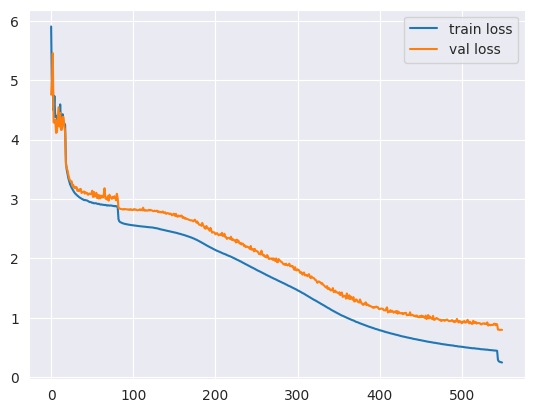

In [25]:
plot_losses(train_losses, test_losses)

# Train, validation, test accuracies

In [26]:
#Train accuracy
yt, tgt, acct = get_pred_n_acc([model], device, train_loader, num_iter = len(train_loader))
#validation accuracy
yv, tgv, accv = get_pred_n_acc([model], device, val_loader, num_iter = len(val_loader))
print(f'Train data, target shapes: {yt.shape, tgt.shape},\n train accuracies {acct}')
print(f'Validation data, target shapes: {yv.shape, tgv.shape},\n validation accuracies {accv}')

Train data, target shapes: ((652092, 4), (652092, 4)),
 train accuracies [94.39204897468456, 81.82802426651455, 78.31793673285364, 37.013642246799535]
Validation data, target shapes: ((72455, 4), (72455, 4)),
 validation accuracies [91.79214684976881, 77.56124491063419, 51.75074183976262, 16.607549513491133]


In [27]:
#Test accuracy
yts, tgts, accts = get_pred_n_acc([model], device, test_loader, num_iter = len(test_loader))
print(f'Test data, target shapes: {yts.shape, tgts.shape},\n test accuracies {accts}')

Test data, target shapes: ((181137, 4), (181137, 4)),
 test accuracies [92.15290084300834, 77.59265086647123, 51.62059656503089, 16.37379442079752]
